In [14]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:47.801164Z","iopub.execute_input":"2025-01-15T04:05:47.801641Z","iopub.status.idle":"2025-01-15T04:05:47.807418Z","shell.execute_reply.started":"2025-01-15T04:05:47.801296Z","shell.execute_reply":"2025-01-15T04:05:47.806247Z"}}
# Cell 1: Import Libraries

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, 
                             recall_score, f1_score)

import cv2  # OpenCV for hair removal
from PIL import Image


In [15]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:08:46.246507Z","iopub.execute_input":"2025-01-15T04:08:46.246849Z","iopub.status.idle":"2025-01-15T04:08:46.316050Z","shell.execute_reply.started":"2025-01-15T04:08:46.246823Z","shell.execute_reply":"2025-01-15T04:08:46.314814Z"}}
# Cell 2: Define 'device'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)


✅ Using Device: cuda


In [16]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:47.808870Z","iopub.execute_input":"2025-01-15T04:05:47.809325Z","iopub.status.idle":"2025-01-15T04:05:47.828375Z","shell.execute_reply.started":"2025-01-15T04:05:47.809282Z","shell.execute_reply":"2025-01-15T04:05:47.827441Z"}}
# Cell 3: Hair Removal

def remove_hair_opencv(img_pil):
    """
    Removes hair from a PIL RGB image using morphological blackhat + inpainting.
    Steps:
      1) Convert PIL -> OpenCV (BGR)
      2) Gray -> Blackhat -> Threshold => hair mask
      3) Inpaint
      4) Return PIL (RGB)
    """
    img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    dst = cv2.inpaint(img_bgr, mask, 1, cv2.INPAINT_TELEA)
    
    dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dst_rgb)


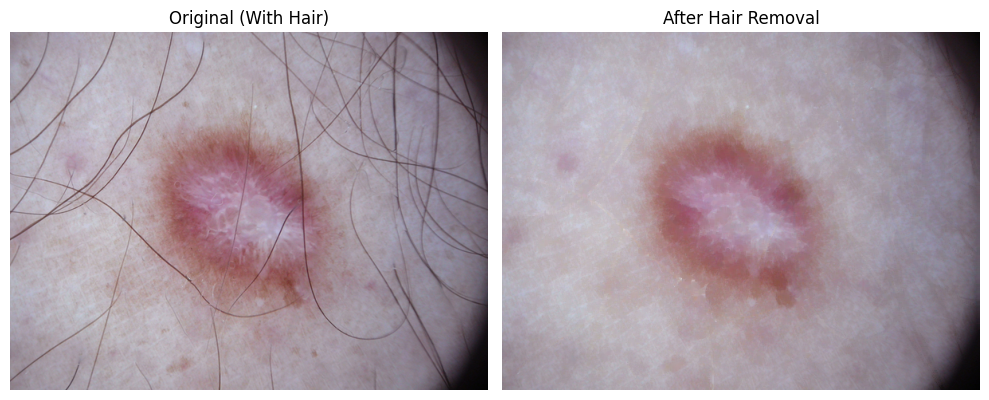

In [17]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:48.555359Z","iopub.execute_input":"2025-01-15T04:05:48.555731Z","iopub.status.idle":"2025-01-15T04:05:48.565020Z","shell.execute_reply.started":"2025-01-15T04:05:48.555702Z","shell.execute_reply":"2025-01-15T04:05:48.564172Z"}}
# Cell 4: Demonstration - Hair Removal

# Example image path
sample_image_path_hr = "/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train/Dermatofibroma/ISIC_0033422.jpg"
original_img_hr = Image.open(sample_image_path_hr).convert('RGB')

hair_removed_img_hr = remove_hair_opencv(original_img_hr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img_hr)
plt.title("Original (With Hair)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hair_removed_img_hr)
plt.title("After Hair Removal")
plt.axis('off')

plt.tight_layout()
plt.show()


In [18]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:48.557325Z","iopub.execute_input":"2025-01-15T04:05:48.557707Z","iopub.status.idle":"2025-01-15T04:05:48.565020Z","shell.execute_reply.started":"2025-01-15T04:05:48.557672Z","shell.execute_reply":"2025-01-15T04:05:48.563954Z"}}
# Cell 5: Custom Transform (Hair Removal)

class HairRemovalTransform:
    """
    Custom transform to remove hair artifacts from images.
    Applies morphological black-hat transformation and inpainting.
    """
    def __call__(self, img_pil):
        # Apply hair removal
        img_hr = remove_hair_opencv(img_pil)
        return img_hr


In [19]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:49.642847Z","iopub.execute_input":"2025-01-15T04:05:49.643132Z","iopub.status.idle":"2025-01-15T04:05:49.659835Z","shell.execute_reply.started":"2025-01-15T04:05:49.643107Z","shell.execute_reply":"2025-01-15T04:05:49.658808Z"}}
# Cell 6: Data Transforms

train_transforms = transforms.Compose([
    HairRemovalTransform(),  # Hair removal
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    HairRemovalTransform(),  # Hair removal
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [21]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:49.661081Z","iopub.execute_input":"2025-01-15T04:05:49.661528Z","iopub.status.idle":"2025-01-15T04:05:50.020707Z","shell.execute_reply.started":"2025-01-15T04:05:49.661480Z","shell.execute_reply":"2025-01-15T04:05:50.019542Z"}}
# Cell 7: Load Dataset

train_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/skin-disease-dataset/Skin_Diseases_Dataset2/val'  # Assuming 'test' instead of 'val'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

print("Classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(test_dataset))


Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']
Number of training images: 697
Number of validation images: 181


In [22]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:05:50.021854Z","iopub.execute_input":"2025-01-15T04:05:50.022202Z","iopub.status.idle":"2025-01-15T04:07:42.945328Z","shell.execute_reply.started":"2025-01-15T04:05:50.022168Z","shell.execute_reply":"2025-01-15T04:07:42.944311Z"}}
# Cell 8: Class Weights & Sampler

class_counts = [0] * len(train_dataset.classes)
for _, lbl in train_dataset:
    class_counts[lbl] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[lbl] for _, lbl in train_dataset]

sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: [80, 81, 80, 80, 80, 80, 80, 56, 80]
Class Weights: tensor([0.0125, 0.0123, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0179, 0.0125])


In [23]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:07:42.946309Z","iopub.execute_input":"2025-01-15T04:07:42.946582Z","iopub.status.idle":"2025-01-15T04:07:42.951311Z","shell.execute_reply.started":"2025-01-15T04:07:42.946561Z","shell.execute_reply":"2025-01-15T04:07:42.950184Z"}}
# Cell 9: DataLoaders

batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)


In [24]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:08:53.487594Z","iopub.execute_input":"2025-01-15T04:08:53.487885Z","iopub.status.idle":"2025-01-15T04:08:53.885026Z","shell.execute_reply.started":"2025-01-15T04:08:53.487862Z","shell.execute_reply":"2025-01-15T04:08:53.884184Z"}}
# Cell 10: ResNet18 Modifications

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers if desired
for name, param in resnet18_model.named_parameters():
    if "layer1" in name or "layer2" in name:
        param.requires_grad = False

# Modify final FC for number of classes (e.g., 9)
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 9)
)

resnet18_model = resnet18_model.to(device)
print("✅ Modified ResNet18:\n", resnet18_model)


✅ Modified ResNet18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [25]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:08:57.777410Z","iopub.execute_input":"2025-01-15T04:08:57.777719Z","iopub.status.idle":"2025-01-15T04:08:57.783571Z","shell.execute_reply.started":"2025-01-15T04:08:57.777697Z","shell.execute_reply":"2025-01-15T04:08:57.782703Z"}}
# Cell 11: Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    resnet18_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

print("🚀 Using a constant LR = 1e-4 (no scheduler).")


🚀 Using a constant LR = 1e-4 (no scheduler).


In [26]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T04:08:59.454545Z","iopub.execute_input":"2025-01-15T04:08:59.454851Z","iopub.status.idle":"2025-01-15T05:02:02.296680Z","shell.execute_reply.started":"2025-01-15T04:08:59.454828Z","shell.execute_reply":"2025-01-15T05:02:02.295782Z"}}
# Cell 12: Training Loop

num_epochs = 50
best_val_acc = 0.0
best_model = copy.deepcopy(resnet18_model.state_dict())

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("🚀 Starting ResNet18 Training (Hair Removal)...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training Phase
    resnet18_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation Phase
    resnet18_model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_loader)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}% | Time: {epoch_time:.2f}s")
    
    # Track best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model = copy.deepcopy(resnet18_model.state_dict())

resnet18_model.load_state_dict(best_model)
print(f"\n✅ Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting ResNet18 Training (Hair Removal)...


Epoch 1/50: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]


Epoch [1/50] | Train Loss: 1.7384 | Train Acc: 40.60% | Val Loss: 0.9775 | Val Acc: 67.40% | Time: 58.10s


Epoch 2/50: 100%|██████████| 44/44 [00:46<00:00,  1.07s/it]


Epoch [2/50] | Train Loss: 0.9136 | Train Acc: 67.86% | Val Loss: 0.6262 | Val Acc: 80.66% | Time: 57.03s


Epoch 3/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [3/50] | Train Loss: 0.6661 | Train Acc: 77.33% | Val Loss: 0.5901 | Val Acc: 77.35% | Time: 53.31s


Epoch 4/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [4/50] | Train Loss: 0.5429 | Train Acc: 80.63% | Val Loss: 0.5213 | Val Acc: 82.87% | Time: 54.05s


Epoch 5/50: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]


Epoch [5/50] | Train Loss: 0.4843 | Train Acc: 82.21% | Val Loss: 0.5334 | Val Acc: 79.01% | Time: 52.37s


Epoch 6/50: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]


Epoch [6/50] | Train Loss: 0.4254 | Train Acc: 86.23% | Val Loss: 0.4884 | Val Acc: 80.66% | Time: 55.36s


Epoch 7/50: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]


Epoch [7/50] | Train Loss: 0.4233 | Train Acc: 85.37% | Val Loss: 0.5701 | Val Acc: 79.01% | Time: 55.04s


Epoch 8/50: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]


Epoch [8/50] | Train Loss: 0.3370 | Train Acc: 89.67% | Val Loss: 0.4821 | Val Acc: 82.87% | Time: 58.13s


Epoch 9/50: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]


Epoch [9/50] | Train Loss: 0.2990 | Train Acc: 89.53% | Val Loss: 0.6703 | Val Acc: 79.56% | Time: 55.66s


Epoch 10/50: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]


Epoch [10/50] | Train Loss: 0.2707 | Train Acc: 91.25% | Val Loss: 0.4708 | Val Acc: 82.32% | Time: 55.99s


Epoch 11/50: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s]


Epoch [11/50] | Train Loss: 0.2469 | Train Acc: 91.97% | Val Loss: 0.5665 | Val Acc: 81.77% | Time: 53.75s


Epoch 12/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [12/50] | Train Loss: 0.2096 | Train Acc: 92.54% | Val Loss: 0.5909 | Val Acc: 81.77% | Time: 53.35s


Epoch 13/50: 100%|██████████| 44/44 [00:45<00:00,  1.02s/it]


Epoch [13/50] | Train Loss: 0.2055 | Train Acc: 93.83% | Val Loss: 0.5353 | Val Acc: 81.22% | Time: 54.86s


Epoch 14/50: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]


Epoch [14/50] | Train Loss: 0.1976 | Train Acc: 94.12% | Val Loss: 0.5425 | Val Acc: 82.87% | Time: 55.39s


Epoch 15/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [15/50] | Train Loss: 0.1725 | Train Acc: 95.27% | Val Loss: 0.7262 | Val Acc: 77.35% | Time: 53.91s


Epoch 16/50: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]


Epoch [16/50] | Train Loss: 0.1643 | Train Acc: 94.12% | Val Loss: 0.6297 | Val Acc: 80.66% | Time: 55.30s


Epoch 17/50: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]


Epoch [17/50] | Train Loss: 0.1774 | Train Acc: 94.98% | Val Loss: 0.5555 | Val Acc: 82.32% | Time: 52.69s


Epoch 18/50: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]


Epoch [18/50] | Train Loss: 0.1456 | Train Acc: 95.84% | Val Loss: 0.5555 | Val Acc: 86.74% | Time: 52.48s


Epoch 19/50: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]


Epoch [19/50] | Train Loss: 0.1504 | Train Acc: 96.41% | Val Loss: 0.6290 | Val Acc: 82.87% | Time: 55.61s


Epoch 20/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [20/50] | Train Loss: 0.1302 | Train Acc: 96.41% | Val Loss: 0.5274 | Val Acc: 83.43% | Time: 53.06s


Epoch 21/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [21/50] | Train Loss: 0.0838 | Train Acc: 97.42% | Val Loss: 0.5418 | Val Acc: 83.98% | Time: 53.69s


Epoch 22/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [22/50] | Train Loss: 0.0854 | Train Acc: 97.85% | Val Loss: 0.5610 | Val Acc: 84.53% | Time: 52.77s


Epoch 23/50: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


Epoch [23/50] | Train Loss: 0.0869 | Train Acc: 97.27% | Val Loss: 0.6292 | Val Acc: 81.22% | Time: 51.90s


Epoch 24/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [24/50] | Train Loss: 0.1179 | Train Acc: 96.41% | Val Loss: 0.6722 | Val Acc: 82.32% | Time: 52.90s


Epoch 25/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [25/50] | Train Loss: 0.1168 | Train Acc: 96.41% | Val Loss: 0.6278 | Val Acc: 83.43% | Time: 53.78s


Epoch 26/50: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]


Epoch [26/50] | Train Loss: 0.0963 | Train Acc: 97.42% | Val Loss: 0.7013 | Val Acc: 81.77% | Time: 53.20s


Epoch 27/50: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]


Epoch [27/50] | Train Loss: 0.0762 | Train Acc: 97.42% | Val Loss: 0.6743 | Val Acc: 81.77% | Time: 54.82s


Epoch 28/50: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]


Epoch [28/50] | Train Loss: 0.0779 | Train Acc: 97.70% | Val Loss: 0.6540 | Val Acc: 79.56% | Time: 56.09s


Epoch 29/50: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s]


Epoch [29/50] | Train Loss: 0.0738 | Train Acc: 97.27% | Val Loss: 0.6303 | Val Acc: 82.87% | Time: 53.93s


Epoch 30/50: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


Epoch [30/50] | Train Loss: 0.0877 | Train Acc: 96.84% | Val Loss: 0.6678 | Val Acc: 83.43% | Time: 54.73s


Epoch 31/50: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


Epoch [31/50] | Train Loss: 0.0872 | Train Acc: 97.13% | Val Loss: 0.6228 | Val Acc: 80.66% | Time: 54.48s


Epoch 32/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [32/50] | Train Loss: 0.0776 | Train Acc: 97.99% | Val Loss: 0.6213 | Val Acc: 80.11% | Time: 54.05s


Epoch 33/50: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


Epoch [33/50] | Train Loss: 0.0539 | Train Acc: 98.85% | Val Loss: 0.5921 | Val Acc: 80.66% | Time: 53.65s


Epoch 34/50: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


Epoch [34/50] | Train Loss: 0.0480 | Train Acc: 98.42% | Val Loss: 0.6191 | Val Acc: 83.98% | Time: 54.21s


Epoch 35/50: 100%|██████████| 44/44 [00:45<00:00,  1.02s/it]


Epoch [35/50] | Train Loss: 0.0737 | Train Acc: 97.99% | Val Loss: 0.6660 | Val Acc: 82.32% | Time: 54.61s


Epoch 36/50: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


Epoch [36/50] | Train Loss: 0.0452 | Train Acc: 99.00% | Val Loss: 0.8527 | Val Acc: 82.32% | Time: 53.80s


Epoch 37/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [37/50] | Train Loss: 0.0592 | Train Acc: 98.13% | Val Loss: 0.6688 | Val Acc: 80.66% | Time: 53.05s


Epoch 38/50: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]


Epoch [38/50] | Train Loss: 0.0533 | Train Acc: 98.71% | Val Loss: 0.6284 | Val Acc: 83.98% | Time: 51.18s


Epoch 39/50: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]


Epoch [39/50] | Train Loss: 0.0696 | Train Acc: 97.85% | Val Loss: 0.7469 | Val Acc: 79.56% | Time: 53.45s


Epoch 40/50: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it]


Epoch [40/50] | Train Loss: 0.0589 | Train Acc: 98.42% | Val Loss: 0.7424 | Val Acc: 79.56% | Time: 58.79s


Epoch 41/50: 100%|██████████| 44/44 [00:49<00:00,  1.11s/it]


Epoch [41/50] | Train Loss: 0.0904 | Train Acc: 97.70% | Val Loss: 0.7621 | Val Acc: 84.53% | Time: 59.76s


Epoch 42/50: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it]


Epoch [42/50] | Train Loss: 0.0437 | Train Acc: 98.85% | Val Loss: 0.7705 | Val Acc: 80.66% | Time: 59.46s


Epoch 43/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [43/50] | Train Loss: 0.0482 | Train Acc: 99.00% | Val Loss: 0.8182 | Val Acc: 84.53% | Time: 61.79s


Epoch 44/50: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]


Epoch [44/50] | Train Loss: 0.0797 | Train Acc: 97.70% | Val Loss: 0.7136 | Val Acc: 79.56% | Time: 61.59s


Epoch 45/50: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]


Epoch [45/50] | Train Loss: 0.0507 | Train Acc: 98.42% | Val Loss: 0.7627 | Val Acc: 82.87% | Time: 61.01s


Epoch 46/50: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]


Epoch [46/50] | Train Loss: 0.0583 | Train Acc: 97.85% | Val Loss: 0.5531 | Val Acc: 84.53% | Time: 59.52s


Epoch 47/50: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Epoch [47/50] | Train Loss: 0.0604 | Train Acc: 97.85% | Val Loss: 0.8219 | Val Acc: 79.56% | Time: 60.28s


Epoch 48/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [48/50] | Train Loss: 0.0582 | Train Acc: 98.28% | Val Loss: 0.7211 | Val Acc: 81.77% | Time: 60.81s


Epoch 49/50: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]


Epoch [49/50] | Train Loss: 0.0510 | Train Acc: 98.71% | Val Loss: 0.6117 | Val Acc: 82.87% | Time: 59.93s


Epoch 50/50: 100%|██████████| 44/44 [00:50<00:00,  1.14s/it]


Epoch [50/50] | Train Loss: 0.0487 | Train Acc: 98.13% | Val Loss: 0.6864 | Val Acc: 82.87% | Time: 60.86s

✅ Training complete! Best Validation Accuracy: 86.74%


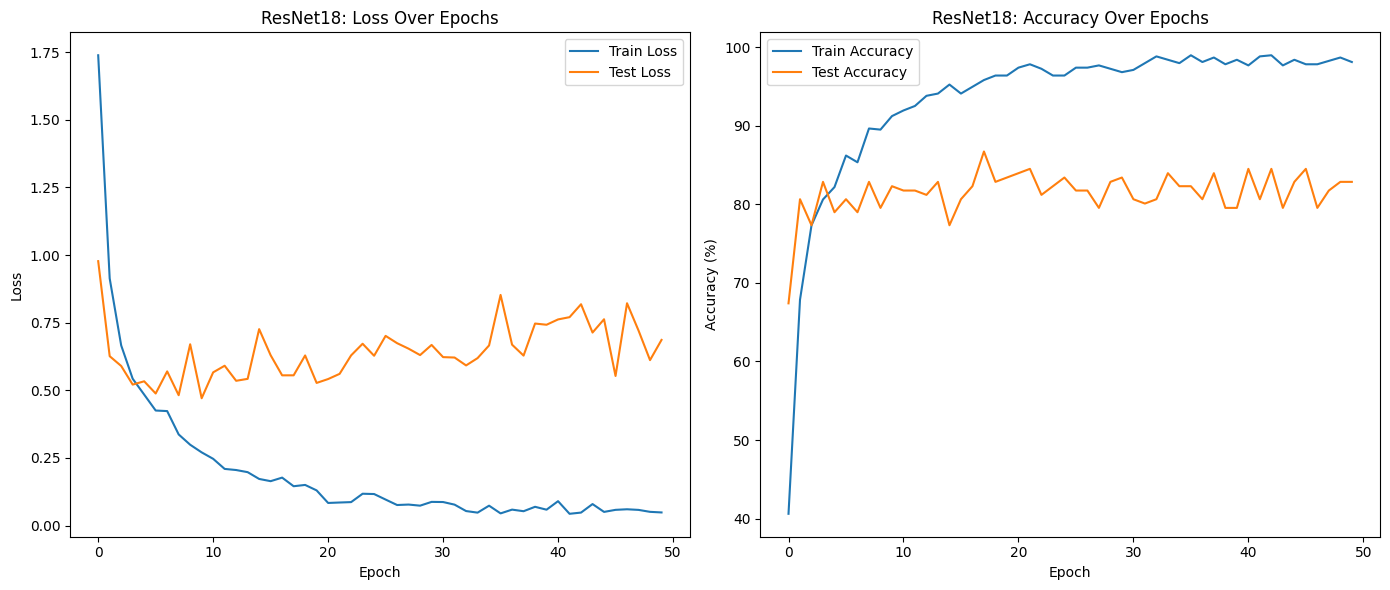

In [31]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T05:02:02.297748Z","iopub.execute_input":"2025-01-15T05:02:02.297998Z","iopub.status.idle":"2025-01-15T05:02:02.718040Z","shell.execute_reply.started":"2025-01-15T05:02:02.297978Z","shell.execute_reply":"2025-01-15T05:02:02.717150Z"}}
# Cell 13: Plotting Curves

plt.figure(figsize=(14, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('ResNet18: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.title('ResNet18: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


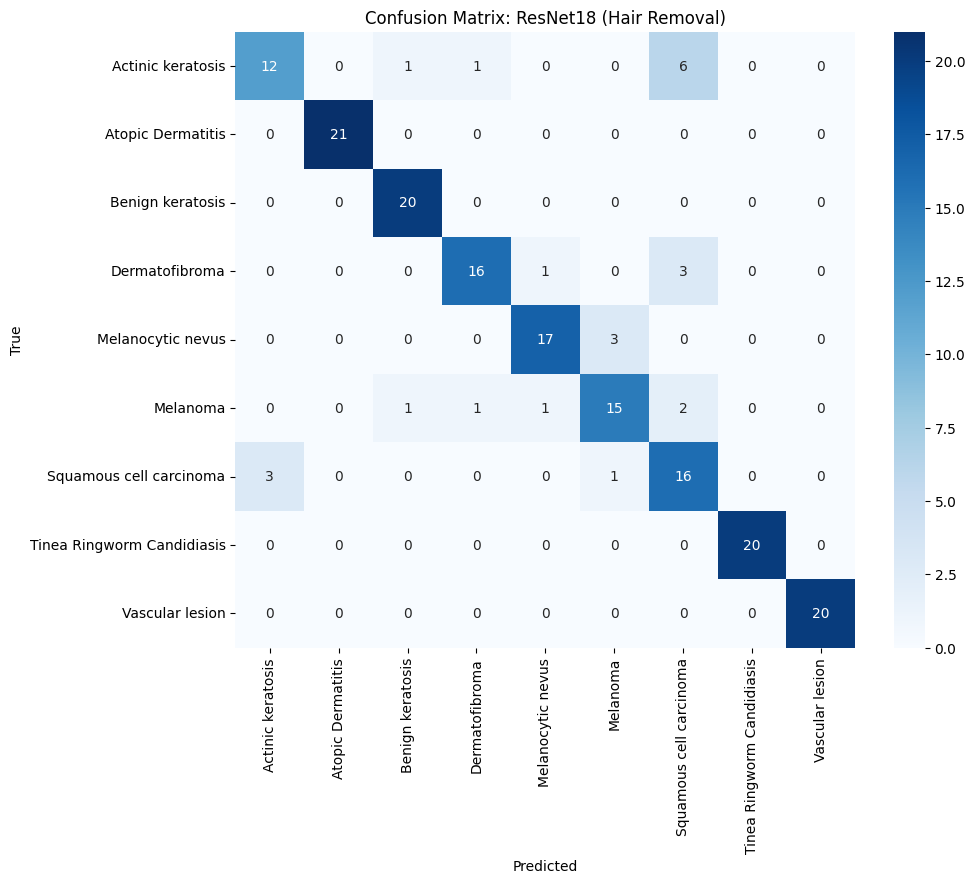


✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.80      0.60      0.69        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.91      1.00      0.95        20
            Dermatofibroma       0.89      0.80      0.84        20
         Melanocytic nevus       0.89      0.85      0.87        20
                  Melanoma       0.79      0.75      0.77        20
   Squamous cell carcinoma       0.59      0.80      0.68        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.87       181
                 macro avg       0.87      0.87      0.87       181
              weighted avg       0.88      0.87      0.87       181


Overall Accuracy: 86.74%
Error Rate: 0.1326
Precision (Macro Avg): 0.8750
Recall (Macr

In [32]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T05:02:02.719326Z","iopub.execute_input":"2025-01-15T05:02:02.719585Z","iopub.status.idle":"2025-01-15T05:02:13.967817Z","shell.execute_reply.started":"2025-01-15T05:02:02.719563Z","shell.execute_reply":"2025-01-15T05:02:13.967146Z"}}
# Cell 14: Final Evaluation

resnet18_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18_model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix: ResNet18 (Hair Removal)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Additional Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
err = 1 - acc

print(f"\nOverall Accuracy: {acc*100:.2f}%")
print(f"Error Rate: {err:.4f}")
print(f"Precision (Macro Avg): {prec:.4f}")
print(f"Recall (Macro Avg): {rec:.4f}")
print(f"F1-Score (Macro Avg): {f1:.4f}")

def calculate_specificity_per_class(conf_mat):
    specificity_per_class = []
    num_classes = conf_mat.shape[0]
    for i in range(num_classes):
        TP = conf_mat[i, i]
        FP = np.sum(conf_mat[:, i]) - TP
        FN = np.sum(conf_mat[i, :]) - TP
        TN = np.sum(conf_mat) - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    return np.mean(specificity_per_class), specificity_per_class

spec_avg, spec_per_class = calculate_specificity_per_class(cm)
print(f"Specificity (Macro Avg): {spec_avg:.4f}")

print("\n✅ Specificity per Class:")
for i, spec in enumerate(spec_per_class):
    print(f"{train_dataset.classes[i]}: {spec:.4f}")


In [29]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T05:02:13.968347Z","iopub.execute_input":"2025-01-15T05:02:13.968630Z","iopub.status.idle":"2025-01-15T05:02:14.015134Z","shell.execute_reply.started":"2025-01-15T05:02:13.968598Z","shell.execute_reply":"2025-01-15T05:02:14.014294Z"}}
# Cell 15: Save Trained Model (Optional)

# Define save path
save_path_with_hair = "resnet18_with_hair_removal.pth"

# Save the trained model
torch.save(resnet18_model.state_dict(), save_path_with_hair)

print(f"✅ Model saved as {save_path_with_hair}")


✅ Model saved as resnet18_with_hair_removal.pth


In [33]:
# %% [code] {"execution":{"iopub.status.busy":"2025-01-15T05:02:14.016221Z","iopub.execute_input":"2025-01-15T05:02:14.016574Z","iopub.status.idle":"2025-01-15T05:02:14.025884Z","shell.execute_reply.started":"2025-01-15T05:02:14.016545Z","shell.execute_reply":"2025-01-15T05:02:14.024927Z"}}
# Cell 16: Load and Use the Saved Model (Optional)

# Function to initialize and load the model
def load_trained_model(save_path, num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    model.load_state_dict(torch.load(save_path))
    model = model.to(device)
    model.eval()
    return model

# Load the saved model
loaded_model_with_hair = load_trained_model(save_path_with_hair, 9)

print("✅ Loaded Trained Model with Hair Removal for Inference.")


✅ Loaded Trained Model with Hair Removal for Inference.


<ipython-input-33-7f83b7de9cd7>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
